In [147]:
import numpy as np
import pandas as pd
import re
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from journal_config import *

In [113]:
df_output_validated = pd.read_csv("journals_response_validated.csv")

In [114]:
df_output_validated = df_output_validated[~( (df_output_validated['publication_year'] == 2013) | (df_output_validated['publication_year'] == 2014) ) ]
df_output_validated['publisher'] = df_output_validated.apply(lambda x: "INFORMS" if x['journal_name'] == "Management Science" else "Wiley", axis=1)

In [161]:
df_output_validated_groupby = (  ( df_output_validated.groupby( ['publisher', 'publication_year', 'is_truly_AI']).agg( {'title': 'count'} ) ).groupby( ['publisher', 'publication_year'] , as_index=False ).apply(lambda x: x / float(x.sum()))  ).reset_index()

C:\Users\Lab\AppData\Local\Temp\ipykernel_20872\3191670107.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_output_validated_groupby = (  ( df_output_validated.groupby( ['publisher', 'publication_year', 'is_truly_AI']).agg( {'title': 'count'} ) ).groupby( ['publisher', 'publication_year'] , as_index=False ).apply(lambda x: x / float(x.sum()))  ).reset_index()


In [162]:
df_output_validated_groupby['pct_AIpaper'] = 1-df_output_validated_groupby['title']
df_output_validated_groupby = (df_output_validated_groupby[df_output_validated_groupby['is_truly_AI'] == False])[['publisher', 'publication_year', 'pct_AIpaper']]

In [163]:
df_output_validated_groupby = df_output_validated_groupby.reset_index(drop=True)

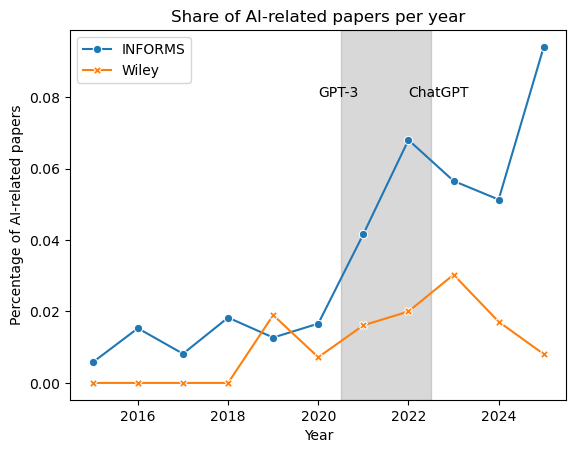

In [173]:
sns.lineplot(
    data=df_output_validated_groupby[df_output_validated_groupby['publisher'] == "INFORMS"], 
    x='publication_year', y='pct_AIpaper',
    marker='o', label='INFORMS'
)
sns.lineplot(
    data=df_output_validated_groupby[df_output_validated_groupby['publisher'] == "Wiley"], 
    x='publication_year', y='pct_AIpaper',
    marker='X', label='Wiley'
)
plt.axvspan(2020.5, 2022.5, color='gray', alpha=0.3)
plt.text(
    x=2020, y=0.08, 
    s="GPT-3",
    fontsize=10, color='black'
)
plt.text(
    x=2022, y=0.08, 
    s="ChatGPT",
    fontsize=10, color='black'
)
plt.xlabel("Year")
plt.ylabel("Percentage of AI-related papers")
plt.title("Share of AI-related papers per year")
plt.show()

### Difference-in-Differences OLS Analysis

Introductory Econometrics (Wooldridge, 2002) Chapter 13.2

In [140]:
# indicator function for INFORMS paper
df_output_validated_groupby['I_informs'] = df_output_validated_groupby.apply(lambda x: 1 if x['publisher'] == "INFORMS" else 0, axis=1)

# indicator function for GPT3 (2021) and chatGPT (2022) - exclude 2021 and 2022
df_output_validated_groupby['I_GPT3'] = df_output_validated_groupby.apply(lambda x: 1 if x['publication_year'] > 2021 else 0, axis=1)
df_output_validated_groupby = df_output_validated_groupby[~( (df_output_validated_groupby['publication_year'] == 2021) | (df_output_validated_groupby['publication_year'] == 2022) ) ]

# interaction term between two indicator functions I_informs * I_GPT3
df_output_validated_groupby['I_interaction'] = df_output_validated_groupby['I_informs'] * df_output_validated_groupby['I_GPT3']

C:\Users\Lab\AppData\Local\Temp\ipykernel_20872\1320424679.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output_validated_groupby['I_interaction'] = df_output_validated_groupby['I_informs'] * df_output_validated_groupby['I_GPT3']


In [141]:
df_output_validated_groupby

,publisher,publication_year,pct_AIpaper,I_informs,I_GPT3,I_interaction
0,INFORMS,2015,0.005780,1,0,0
1,INFORMS,2016,0.015306,1,0,0
2,INFORMS,2017,0.008163,1,0,0
3,INFORMS,2018,0.018293,1,0,0
4,INFORMS,2019,0.012698,1,0,0
5,INFORMS,2020,0.016611,1,0,0
8,INFORMS,2023,0.056555,1,1,1
9,INFORMS,2024,0.051339,1,1,1
10,INFORMS,2025,0.094077,1,1,1
11,Wiley,2015,0.000000,0,0,0


In [152]:
difference_in_differences = (
    (df_output_validated_groupby[ (df_output_validated_groupby['I_informs'] == 1) & (df_output_validated_groupby['I_GPT3'] == 1) ]['pct_AIpaper'].mean() -  
    df_output_validated_groupby[ (df_output_validated_groupby['I_informs'] == 1) & (df_output_validated_groupby['I_GPT3'] == 0) ]['pct_AIpaper'].mean() ) 
) - (
    df_output_validated_groupby[ (df_output_validated_groupby['I_informs'] == 0) & (df_output_validated_groupby['I_GPT3'] == 1) ]['pct_AIpaper'].mean() - 
    df_output_validated_groupby[ (df_output_validated_groupby['I_informs'] == 0) & (df_output_validated_groupby['I_GPT3'] == 0) ]['pct_AIpaper'].mean() 
)
print(difference_in_differences)

0.04037517912054536


In [156]:
model = smf.ols( "pct_AIpaper ~ I_informs + I_GPT3 + I_interaction", data=df_output_validated_groupby[['pct_AIpaper', 'I_informs', 'I_GPT3', 'I_interaction']] )
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            pct_AIpaper   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     22.58
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.25e-05
Time:                        06:57:54   Log-Likelihood:                 57.570
No. Observations:                  18   AIC:                            -107.1
Df Residuals:                      14   BIC:                            -103.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0044      0.005      0.954

In [157]:
result.bse

Intercept        0.004574
I_informs        0.006468
I_GPT3           0.007922
I_interaction    0.011203
dtype: float64

In [158]:
result.pvalues

Intercept        0.356216
I_informs        0.212707
I_GPT3           0.095939
I_interaction    0.002875
dtype: float64

null hypthesis H_0: GPT3 and ChatGPT did not have an impact on AI-related activity on Operations Research papers relative to other Finance papers

In [159]:
0.0404 /0.011203

3.6061769168972595

with a z_score > 3 and p-value of 0.0028, we can reject H_0 -- however, sample size is limited, so data collection from more publishers/journals is necessary to confidently reject H_0